# Imports

In [2]:
from rbclib import RBCPath
from pathlib import Path
import pandas as pd
import numpy as np

# Load data


In [3]:
rbcdata_path = Path('/home/jovyan/shared/data/RBC')
train_filepath = rbcdata_path / 'train_participants.tsv'
test_filepath = rbcdata_path / 'test_participants.tsv'

with train_filepath.open('r') as f:
    train_data = pd.read_csv(f, sep='\t')
with test_filepath.open('r') as f:
    test_data = pd.read_csv(f, sep='\t')

all_data = pd.concat([train_data, test_data])


In [4]:
def load_fsdata(participant_id, local_cache_dir=(Path.home() / 'cache')):
    "Loads and returns the dataframe of a PNC participant's FreeSurfer data."

    # Check that the local_cache_dir exists and make it if it doesn't.
    if local_cache_dir is not None:
        local_cache_dir = Path(local_cache_dir)
        local_cache_dir.mkdir(exist_ok=True)
    
    # Make the RBCPath and find the appropriate file:
    pnc_freesurfer_path = RBCPath(
        'rbc://PNC_FreeSurfer/freesurfer',
        # We provide the local_cache_dir to the RBCPath object; all paths made
        # from this object will use the same cache directory.
        local_cache_dir=local_cache_dir)
    participant_path = pnc_freesurfer_path / f'sub-{participant_id}'
    tsv_path = participant_path / f'sub-{participant_id}_regionsurfacestats.tsv'

    # Use pandas to read in the TSV file:
    with tsv_path.open('r') as f:
        data = pd.read_csv(f, sep='\t')

    # Return the loaded data:
    return data
    data

In [5]:
def get_features_subject(data):
    # filter by atlas, get one row of mean volume by region
    df_ = (data
     .query("atlas=='aparc'")
     .groupby(['StructName'])
     ['GrayVol']
     .mean()
     .to_frame()
     .transpose()
    )
    # some pandas weird things to make the output nice
    df_.columns.name = 'index'
    df_ = df_.reset_index(drop=True)
    # add the subject id to be able to concat data later on
    df_['subject_id'] = data['subject_id'].unique()
    return df_


In [6]:
participants = list(all_data['participant_id'].unique())
feature_df_list = []
for participant in participants[:3]:
    df_ = load_fsdata(participant)
    feature_df_list.append(get_features_subject(df_))
feature_df = pd.concat(feature_df_list)
feature_df

index,bankssts,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,frontalpole,fusiform,inferiorparietal,inferiortemporal,insula,...,precuneus,rostralanteriorcingulate,rostralmiddlefrontal,superiorfrontal,superiorparietal,superiortemporal,supramarginal,temporalpole,transversetemporal,subject_id
0,2636.0,2001.0,6526.5,4226.0,2625.5,1433.0,9963.5,16145.0,11816.5,7008.5,...,11686.5,2612.0,17090.5,25891.5,14106.5,15273.0,11645.5,2926.0,1261.5,sub-1000393599
0,2561.0,1496.5,5812.0,3069.0,1506.0,1046.0,9044.5,13748.5,10105.5,8036.0,...,9481.0,2166.5,15741.5,25257.0,12508.5,14181.5,12747.5,2141.0,1019.0,sub-1001970838
0,2882.5,2223.5,6976.0,3144.0,2025.0,1154.0,11627.5,18001.0,11854.5,6900.0,...,10801.5,2456.0,17091.0,23280.5,14245.5,13120.0,12955.0,2532.0,1003.5,sub-1007995238


In [7]:
## Diego's orginal with the aparc atlas (anatomical)


all_features = pd.read_csv('derivatives/features.csv')
train = all_features.query("is_train")
# select whatever features you want

selected_features = ['internalizing_mcelroy_harmonized_all_samples', 'externalizing_mcelroy_harmonized_all_samples', 'attention_mcelroy_harmonized_all_samples', 'age']


# make sure p_factor is the last columns
train_vars = train[selected_features+['p_factor']]
# Import the LinearRegression type:
from sklearn.linear_model import LinearRegression
# LinearRegression requires a matrix whose columns are the variables and whose
# final column is the value being predicted (the p_factor for us). We can
# extract these columns straight from the dataframes we generated.
train_matrix = train_vars.values
# We need to exclude rows with NaNs for training:
train_okrows = np.all(~np.isnan(train_matrix), axis=1)
train_matrix = train_matrix[train_okrows]
# Train the regression using the training matrix:
lreg = LinearRegression()
## the first argument should be a matrix with all independent variables, the second argument is just the dependent variable (p_factor)
lreg.fit(train_matrix[:, :-1], train_matrix[:, -1])
# Display the trained regression parameters:
print("Linear Regression:")
print("  Intercept:", lreg.intercept_)
print("  Slope:", lreg.coef_)

Linear Regression:
  Intercept: -1.2640450182259606
  Slope: [0.15393905 0.16985111 0.11375175 0.05863657]


In [8]:
## Version with MLP artificial neural network instead of linear regression

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

selected_features = ['frontalpole', 'internalizing_mcelroy_harmonized_all_samples', 'externalizing_mcelroy_harmonized_all_samples', 'attention_mcelroy_harmonized_all_samples', 'age']

# Combine features + target
train_vars = train[selected_features + ['p_factor']]
train_matrix = train_vars.values

# Drop rows with NaNs
train_okrows = np.all(~np.isnan(train_matrix), axis=1)
X_train = train_matrix[train_okrows, :-1]
y_train = train_matrix[train_okrows, -1]

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train MLP
lreg = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
lreg.fit(X_train_scaled, y_train)

print("MLP Regressor:")
print("  Loss:", lreg.loss_)
print("  Number of iterations:", lreg.n_iter_)

# Extract test features
test = all_features.query("not is_train")
X_test = test[selected_features].values

# Keep only rows without NaNs
test_okrows = np.all(~np.isnan(X_test), axis=1)
X_test = X_test[test_okrows]

# Apply same normalization as training
X_test_scaled = scaler.transform(X_test)

# Predict p-factors using trained MLPRegressor
p_factor_predictions = lreg.predict(X_test_scaled)

# Convert to list if needed
p_factor_predictions_list = p_factor_predictions.tolist()

# Optionally preview
print("Predicted p-factor values (first 10):")
print(p_factor_predictions_list[:10])

# Create DataFrame to save
pred_df = test.loc[test_okrows, ['subject_id']].copy()  # or another ID column
pred_df['predicted_p_factor'] = p_factor_predictions

# Save to CSV
pred_df.to_csv('predicted_p_factors.csv', index=False)



MLP Regressor:
  Loss: 0.07376343061286443
  Number of iterations: 238
Predicted p-factor values (first 10):
[-0.008503821053831878, -0.47383785174350646, -0.34737859031389684, 0.6209164527989731, -0.0827124251800877, 0.26566470527591357, -1.2524664669443306, -0.7536030911305194, -1.5970691100058303, -1.2755941544881548]


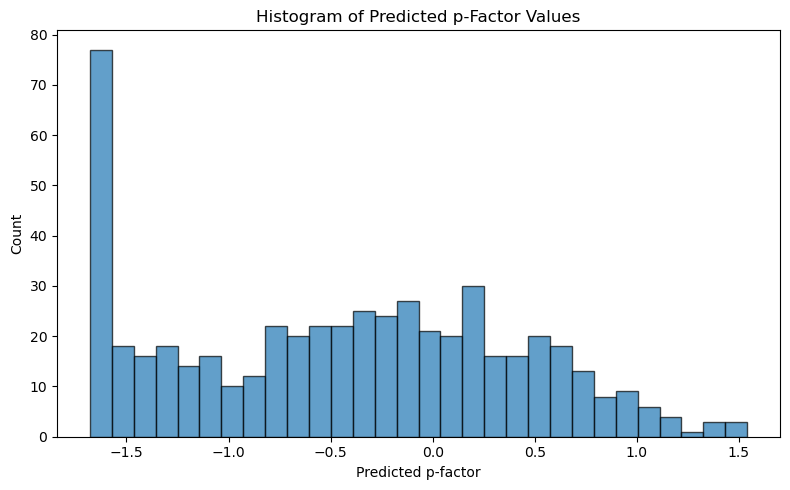

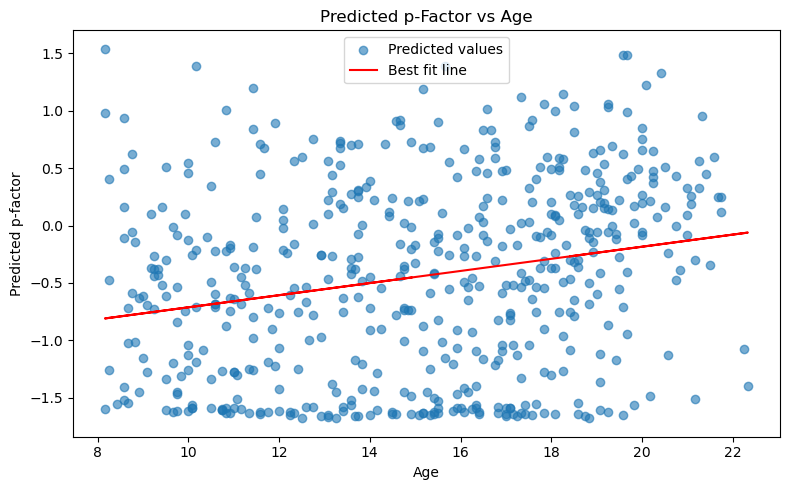

In [9]:
# Save full predictions with ID
pred_df = test.loc[test_okrows, ['subject_id']].copy()
pred_df['predicted_p_factor'] = p_factor_predictions
pred_df.to_csv('predicted_p_factors.csv', index=False)

# Histogram of predicted values
plt.figure(figsize=(8, 5))
plt.hist(p_factor_predictions, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Predicted p-Factor Values')
plt.xlabel('Predicted p-factor')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('p_factor_histogram.png')
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Optional scatter plot: p-factor vs age with line of best fit
if 'age' in selected_features:
    age_vals = test.loc[test_okrows, 'age'].values

    # Create scatter
    plt.figure(figsize=(8, 5))
    plt.scatter(age_vals, p_factor_predictions, alpha=0.6, label='Predicted values')

    # Compute line of best fit
    slope, intercept = np.polyfit(age_vals, p_factor_predictions, deg=1)
    best_fit_line = slope * age_vals + intercept
    plt.plot(age_vals, best_fit_line, color='red', label='Best fit line')

    # Plot styling
    plt.title('Predicted p-Factor vs Age')
    plt.xlabel('Age')
    plt.ylabel('Predicted p-factor')
    plt.legend()
    plt.tight_layout()
    plt.savefig('p_factor_vs_age_scatter.png')
    plt.show()


In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on training data
y_train_pred = lreg.predict(X_train_scaled)

# Compute MSE
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

print("Training Set Evaluation:")
print("  Mean Squared Error:", mse_train)
print("  Root Mean Squared Error:", rmse_train)


Training Set Evaluation:
  Mean Squared Error: 0.14492996744863934
  Root Mean Squared Error: 0.3806966869420318


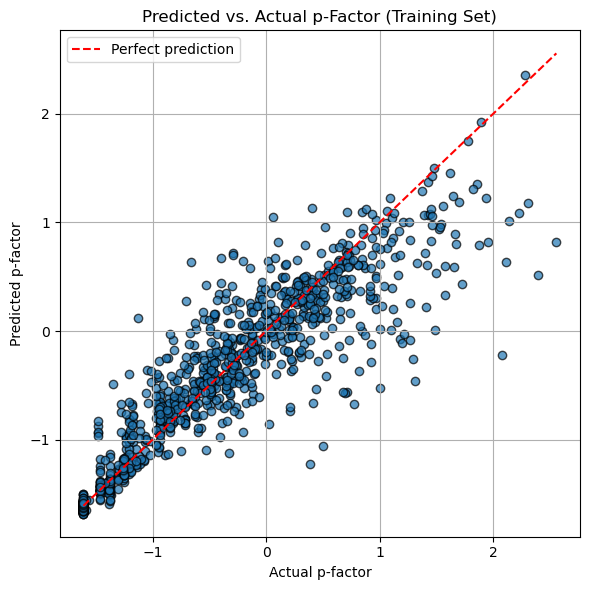

In [11]:
import matplotlib.pyplot as plt

# Scatter plot: predicted vs. actual on training set
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_train_pred, alpha=0.7, edgecolor='k')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect prediction')

plt.title('Predicted vs. Actual p-Factor (Training Set)')
plt.xlabel('Actual p-factor')
plt.ylabel('Predicted p-factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('train_pred_vs_actual.png')
plt.show()


/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


5-Fold Stratified CV Results:
  Mean Squared Error: 0.3005891495548902
  Root Mean Squared Error: 0.5482601112199301


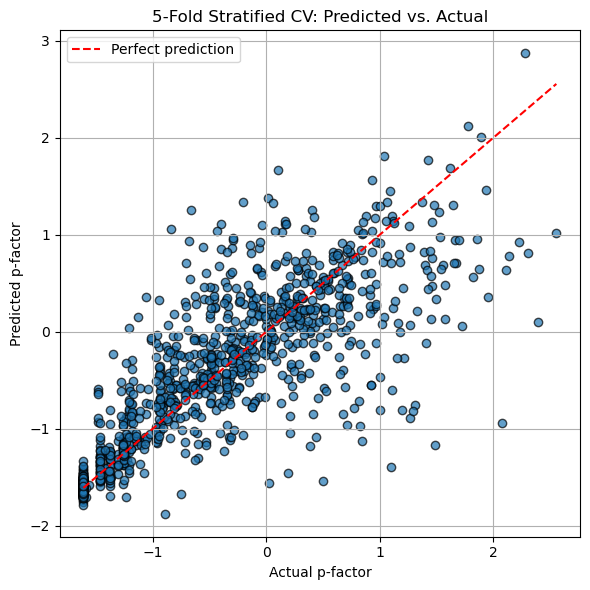

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------
# Set up data
# ---------------------
selected_features = ['frontalpole', 'internalizing_mcelroy_harmonized_all_samples',
                     'externalizing_mcelroy_harmonized_all_samples',
                     'attention_mcelroy_harmonized_all_samples', 'age']

# Drop NaNs
train_vars = train[selected_features + ['p_factor']].dropna()
X = train_vars[selected_features].values
y = train_vars['p_factor'].values

# Bin the continuous target for stratification
n_bins = 5  # Can adjust depending on size
y_binned = pd.qcut(y, q=n_bins, labels=False)

# ---------------------
# Stratified K-Fold
# ---------------------
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

y_true_all = []
y_pred_all = []

for train_index, test_index in skf.split(X, y_binned):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale within each fold
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train MLP
    model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred_fold = model.predict(X_test_scaled)
    y_pred_all.extend(y_pred_fold)
    y_true_all.extend(y_test)

# ---------------------
# Evaluation
# ---------------------
mse = mean_squared_error(y_true_all, y_pred_all)
rmse = np.sqrt(mse)

print(f"{k}-Fold Stratified CV Results:")
print("  Mean Squared Error:", mse)
print("  Root Mean Squared Error:", rmse)

# ---------------------
# Optional: Plot predictions
# ---------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_true_all, y_pred_all, alpha=0.7, edgecolor='k')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], 'r--', label='Perfect prediction')
plt.xlabel('Actual p-factor')
plt.ylabel('Predicted p-factor')
plt.title(f'{k}-Fold Stratified CV: Predicted vs. Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('stratified_kfold_pred_vs_actual.png')
plt.show()
